In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
import numpy as np

In [3]:
from exp.nb_01 import load_data
from exp.nb_02 import gini_score

In [4]:
train_df, test_df = load_data(keep_df=True)

/home/ubuntu/anaconda3/envs/thanos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/ubuntu/anaconda3/envs/thanos/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [5]:
# train_df.head()

In [6]:
#export
from fastai.tabular import FillMissing, Categorify, Normalize

def feature_selector(train_df, test_df, n_valid=6000):
    params = {}
    procs = [FillMissing, Categorify, Normalize]
#     procs = [Categorify, Normalize]
    dep_var = 'label'
    
    #cat_names = data.select_dtypes(exclude=['int', 'float']).columns
    cat_names = list(train_df.select_dtypes(exclude=['int', 'float']).columns)
    
    #cont_names = data.select_dtypes([np.number]).columns
    cont_names = list(train_df.select_dtypes([np.number]).columns)
    cont_names.remove('label')
    cont_names.remove('id')
    print(f"Category {cat_names},\n\nContinue: {cont_names}")
    
    train_df = train_df[cat_names + cont_names + [dep_var]]

    test_ids = test_df['id']
    del test_df['id']
    n = len(train_df)
    valid_ratio=0.8
    valid_ids = list(range(n - n_valid,n))

    embed_params = {'layers': [1000, 500],
          'ps': [0.002,0.02],
          'emb_drop': 0.1,
          'emb_szs':{},
         }

    params = {'train_df': train_df, 
              'test_df': test_df, 
              'cat_names': cat_names, 
              'cont_names': cont_names, 
              'procs': procs, 
              'dep_var': dep_var, 
              'valid_ids': valid_ids}
    return test_ids, valid_ids, embed_params, params

In [7]:
test_ids, valid_ids, embed_params, params = feature_selector(train_df, test_df)

Category ['province', 'district', 'maCv', 'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11', 'FIELD_12', 'FIELD_13', 'FIELD_17', 'FIELD_18', 'FIELD_19', 'FIELD_20', 'FIELD_23', 'FIELD_24', 'FIELD_25', 'FIELD_26', 'FIELD_27', 'FIELD_28', 'FIELD_29', 'FIELD_30', 'FIELD_31', 'FIELD_35', 'FIELD_36', 'FIELD_37', 'FIELD_38', 'FIELD_39', 'FIELD_40', 'FIELD_41', 'FIELD_42', 'FIELD_43', 'FIELD_44', 'FIELD_45', 'FIELD_47', 'FIELD_48', 'FIELD_49'],

Continue: ['age_source1', 'age_source2', 'FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6', 'FIELD_14', 'FIELD_15', 'FIELD_16', 'FIELD_21', 'FIELD_22', 'FIELD_32', 'FIELD_33', 'FIELD_34', 'FIELD_46', 'FIELD_50', 'FIELD_51', 'FIELD_52', 'FIELD_53', 'FIELD_54', 'FIELD_55', 'FIELD_56', 'FIELD_57']


In [8]:
#export
from fastai.tabular import TabularList, FloatList
def load_data_bunch(train_df, test_df, cat_names, cont_names, procs, dep_var, valid_ids, with_valid=True):
    test = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
    if with_valid:
        data = (TabularList.from_df(train_df, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                            .split_by_idx(valid_ids)
                            .label_from_df(cols = dep_var)
                            .add_test(test, label=0)
                            .databunch())
    else:
        data = (TabularList.from_df(train_df, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                    .split_none()
                    .label_from_df(cols = dep_var)
                    .add_test(test, label=0)
                    .databunch())
    return data

In [9]:
# Train Data Bunch
data = load_data_bunch(**params)

data.show_batch(rows=3)

province,district,maCv,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,FIELD_12,FIELD_13,FIELD_17,FIELD_18,FIELD_19,FIELD_20,FIELD_23,FIELD_24,FIELD_25,FIELD_26,FIELD_27,FIELD_28,FIELD_29,FIELD_30,FIELD_31,FIELD_35,FIELD_36,FIELD_37,FIELD_38,FIELD_39,FIELD_40,FIELD_41,FIELD_42,FIELD_43,FIELD_44,FIELD_45,FIELD_47,FIELD_48,FIELD_49,age_source1_na,age_source2_na,FIELD_2_na,FIELD_3_na,FIELD_4_na,FIELD_5_na,FIELD_6_na,FIELD_16_na,FIELD_21_na,FIELD_22_na,FIELD_50_na,FIELD_51_na,FIELD_52_na,FIELD_53_na,FIELD_54_na,FIELD_55_na,FIELD_56_na,FIELD_57_na,age_source1,age_source2,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_14,FIELD_15,FIELD_16,FIELD_21,FIELD_22,FIELD_32,FIELD_33,FIELD_34,FIELD_46,FIELD_50,FIELD_51,FIELD_52,FIELD_53,FIELD_54,FIELD_55,FIELD_56,FIELD_57,target
#na#,#na#,Công nhân may,[],FEMALE,DN,GH,3,None,TH,None,True,True,False,True,None,False,False,True,True,None,None,None,Four,FALSE,TRUE,False,VN,None,I,Zezo,None,Two,2,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.1650,-0.6981,0.5377,0.5513,0.8041,-0.5854,-0.8886,-0.3145,1.2271,1.2343,-0.2477,-0.0061,-0.7455,-0.7163,0.6815,-0.9138,-0.8197,-0.3003,-0.2735,4.1023,4.2453,-0.2564,-0.3585,3.5515,3.5624,0
#na#,#na#,#na#,[],#na#,na,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,True,True,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,-0.1650,-0.1685,0.5377,-1.8137,-1.1822,-0.5854,-0.8886,-0.3145,1.2271,1.2343,-0.2477,-0.0061,-0.2612,1.3960,0.6815,1.0942,-0.8197,-0.3003,-0.0022,-0.2454,-0.2354,-0.2564,0.0631,-0.2145,-0.2078,0
#na#,#na#,Nhân viên hợp đồng,[],MALE,XK,GH,12,None,KC,G8,True,True,True,True,None,False,False,True,True,None,None,None,One,FALSE,True,False,VN,None,I,Zezo,None,Two,1,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.1650,1.4204,-1.8597,0.5513,1.5701,-0.5854,-0.8886,-0.3145,1.2271,1.2343,-0.2477,-0.0061,1.0022,-0.7163,0.6815,-0.9138,1.2199,3.0263,-1.8178,-0.2454,-0.2354,0.9524,-1.4828,-0.2145,-0.2078,0


In [10]:
#export
from fastai.tabular import *
def load_learner(data, params): return tabular_learner(data, **params, metrics=accuracy, callback_fns=ShowGraph)

In [11]:
learn = load_learner(data, embed_params)

In [12]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(66, 17)
    (1): Embedding(710, 63)
    (2): Embedding(2552, 129)
    (3): Embedding(5922, 207)
    (4): Embedding(3, 3)
    (5): Embedding(36, 12)
    (6): Embedding(3, 3)
    (7): Embedding(42, 13)
    (8): Embedding(6, 4)
    (9): Embedding(215, 32)
    (10): Embedding(9, 5)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(2, 2)
    (15): Embedding(5, 4)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(4, 3)
    (22): Embedding(3, 3)
    (23): Embedding(6, 4)
    (24): Embedding(4, 3)
    (25): Embedding(6, 4)
    (26): Embedding(3, 3)
    (27): Embedding(43, 13)
    (28): Embedding(10, 6)
    (29): Embedding(6, 4)
    (30): Embedding(4, 3)
    (31): Embedding(7, 5)
    (32): Embedding(4, 3)
    (33): Embedding(4, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (36): E

In [13]:
# select the appropriate learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


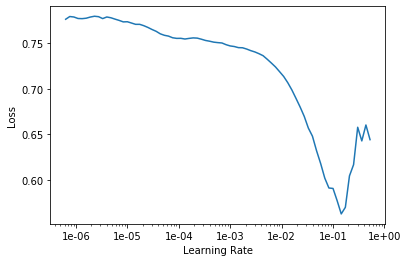

In [14]:
# we typically find the point where the slope is steepest
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.093459,0.087969,0.982833,00:53


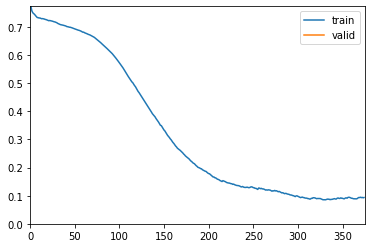

In [15]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(1, max_lr=slice(1e-03))

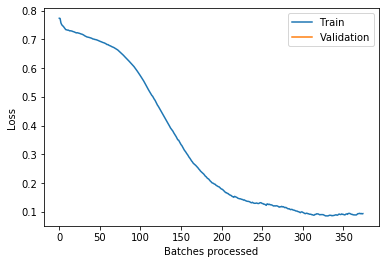

In [16]:
# Analyse our model
learn.model
learn.recorder.plot_losses()

In [17]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Valid)
y_score = np.array(predictions[:,1].tolist())
y_valid = list(train_df.iloc[valid_ids].label)
gini_score(y_valid, y_score)

0.07189108827756763

In [18]:
sum(y_score > 0.5)

0

In [19]:
min(y_score), max(y_score)

(2.9112854463164695e-05, 0.118144191801548)

In [20]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.array(predictions[:,0].tolist())
# create submission file to submit in Kaggle competition
submission = pd.DataFrame({'id': test_ids, 'label': labels})
submission.to_csv('data/submission.csv', index=False)
submission.head()

,id,label
0,30000,0.985143
1,30001,0.985723
2,30002,0.986731
3,30003,0.988452
4,30004,0.985130


In [21]:
!python notebook2script.py 04_fast_ai_v1.ipynb

Converted 04_fast_ai_v1.ipynb to exp/nb_04.py
